In [1]:

# -----------------------------mesh import-------------------------------
from __future__ import print_function
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.interpolate import griddata
%matplotlib inline
plt.style.use('classic')
import time
import scipy

fname = "SG40_cut_gmsh2"
mesh = Mesh(fname + ".xml")
subdomains = MeshFunction("size_t", mesh, fname + "_physical_region.xml")
facets = MeshFunction("size_t", mesh, fname + "_facet_region.xml")

In [3]:
# Periodic Boundary Conditions

vertices = np.array([[0.,0,0],   # 0: Origin
                     [0.1,0,0],   # 1: Right
                     [0,0.5,0],   # 2: Top
                     [0,0,0.5],   # 3: Front
                     [0,0,0],   # 4: left
                     [0,-0.5,0],   # 5: Bottom
                     [0,0,-0.5]])  # 6: Back

class PeriodicBoundary(SubDomain):
    def __init__(self, vertices, tolerance=DOLFIN_EPS):
        """ vertices stores the coordinates of the 4 unit cell corners"""
        SubDomain.__init__(self, tolerance)
        self.tol = tolerance
        self.vv = vertices
        self.a1 = self.vv[1,:]-self.vv[4,:] # first vector generating periodicity
        
    def inside(self, x, on_boundary):
        # faces
        left = near(x[0],self.vv[4,0]) 

        return bool((left) and on_boundary)

    def map(self, x, y):
        """ Mapping the right boundary to left and top to bottom"""
        
        # faces
        right = near(x[0],self.vv[1,0])

        if right:
            y[0] = x[0] - (self.a1[0])
            y[1] = x[1] - (self.a1[1])
            y[2] = x[2] - (self.a1[2])
        else: 
            y[0] = x[0] 
            y[1] = x[1] 
            y[2] = x[2] 
#-------------------Periodic Boundary Conditions End---------------

In [4]:
# Material properties Initialization
# GELCOAT-1
E1,E2,E3=3.4400E+09, 3.4400E+09, 3.4400E+09
G12,G13,G23= 1.3230E+09, 1.3230E+09, 1.3230E+09
v12,v13,v23 = 0.3,0.3,0.3
material_parameters=[(E1,E2,E3,G12,G13,G23,v12,v13,v23)]

# Gtriax-2

E1,E2,E3= 2.8700E+10, 1.6600E+10, 1.6700E+10
G12,G13,G23= 8.4000E+09, 3.4900E+09, 3.4900E+09
v12,v13,v23 = 0.50, 0.17, 0.0
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))


# GUNI- 3
E1,E2,E3= 4.4600E+10, 1.7000E+10, 1.6700E+10
G12,G13,G23= 3.2700E+09, 3.5000E+09, 3.4800E+09
v12,v13,v23 = 0.26,0.26,0.35
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))


# FOAM- 4
E1,E2,E3= 1.2920E+08, 1.2920E+08, 1.2920E+08
G12,G13,G23= 4.8947E+07, 4.8947E+07, 4.8947E+07
v12,v13,v23 = 0.32,0.32,0.32
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))

# CarbonUD 5
E1,E2,E3= 1.1450E+11, 8.3900E+09, 8.3900E+09
G12,G13,G23= 5.9900E+09,5.9900E+09, 5.9900E+09
v12,v13,v23 = 0.27,0.27,0.27
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))

nphases = len(material_parameters)

x = SpatialCoordinate(mesh)
Eps2T=as_tensor([(1,0,0,0,0,0),
                (0,0,0,0,x[1],-x[2]),
                (x[2],0,0,0,0,0),
                (-x[1],0,0,0,0,0)]) 

Eps2=as_tensor([(1,0,x[2],-x[1]),
                (0,0,0,0),
                (0,0,0,0),
                (0,0,0,0),
               (0,x[1],0,0),
               (0,-x[2],0,0)])

def eps(v):
    E1= as_vector([v[0].dx(0),v[1].dx(1),v[2].dx(2),(v[1].dx(2)+v[2].dx(1)),(v[0].dx(2)+v[2].dx(0)),(v[0].dx(1)+v[1].dx(0))]) 
  #  return as_vector([E1[1],E1[2],E1[0],E1[4],E1[5],E1[3]])
    return E1
# 2-> 1 
# 3-> 2
# 1-> 3
# (33,11,22,12,23,13)

def eps_t(v):
    E1= as_vector([v[0].dx(0),v[1].dx(1),v[2].dx(2),(v[1].dx(2)+v[2].dx(1)),(v[0].dx(2)+v[2].dx(0)),(v[0].dx(1)+v[1].dx(0))]) 
   
    return as_tensor([(E1[0],0.5*E1[5],0.5*E1[4]),(0.5*E1[5],E1[1],0.5*E1[3]),(0.5*E1[4],0.5*E1[3],E1[2])])

def sigma(v, i,Eps):
    E1,E2,E3,G12,G13,G23,v12,v13,v23= material_parameters[i]
    S=np.zeros((6,6))
    S[0,0], S[1,1], S[2,2]=1/E1, 1/E2, 1/E3
    S[0,1], S[0,2]= -v12/E1, -v13/E1
    S[1,0], S[1,2]= -v12/E1, -v23/E2
    S[2,0], S[2,1]= -v13/E1, -v23/E2
    S[3,3], S[4,4], S[5,5]= 1/G23, 1/G13, 1/G12    
    C=as_tensor(np.linalg.inv(S))
    s1= dot(C,eps(v)+Eps)
    return as_tensor([(s1[0],s1[5],s1[4]),(s1[5],s1[1],s1[3]),(s1[4],s1[3],s1[2])]),C

def gamma_l(v):
    E1= as_vector([v[0],0,0,0, 0.5*v[2],0.5*v[1]])
    E2= as_vector([v[0],0,0,0, v[2],v[1]])
  #  return as_vector([E1[1],E1[2],E1[0],E1[4],E1[5],E1[3]])
    return as_tensor([(E1[0],E1[5],E1[4]),(E1[5],E1[1],E1[3]),(E1[4],E1[3],E1[2])]),E2

def sigma_gl(v, i, Eps):
    E1,E2,E3,G12,G13,G23,v12,v13,v23= material_parameters[i]
    S=np.zeros((6,6))
    S[0,0], S[1,1], S[2,2]=1/E1, 1/E2, 1/E3
    S[0,1], S[0,2]= -v12/E1, -v13/E1
    S[1,0], S[1,2]= -v12/E1, -v23/E2
    S[2,0], S[2,1]= -v13/E1, -v23/E2
    S[3,3], S[4,4], S[5,5]= 1/G23, 1/G13, 1/G12    
    C=as_tensor(np.linalg.inv(S))
    s1= dot(C,gamma_l(v)[1]+Eps)
    return as_tensor([(s1[0],s1[5],s1[4]),(s1[5],s1[1],s1[3]),(s1[4],s1[3],s1[2])])

# FE Function Space

Ve = VectorElement("CG", mesh.ufl_cell(), 1,dim=3)
Re = VectorElement("R", mesh.ufl_cell(), 0,dim=4)
W = FunctionSpace(mesh, MixedElement([Ve, Re]), constrained_domain=PeriodicBoundary(vertices, tolerance=1e-10))
V = FunctionSpace(mesh, Ve)

v_,lamb_ = TestFunctions(W)
dv, dlamb = TrialFunctions(W)
Eps= as_vector((1,0,0,0,0,0))
dx = Measure('dx')(domain=mesh, subdomain_data=subdomains)

c1=lamb_[0]*dv[0]+lamb_[1]*dv[1]+lamb_[2]*dv[2]
c2=dlamb[0]*v_[0]+dlamb[1]*v_[1]+dlamb[2]*v_[2]
#c3=lamb_[3]*(dv[1].dx(1)-dv[2].dx(0))+dlamb[3]*(v_[1].dx(1)-v_[2].dx(0))  initial
c3=lamb_[3]*(dv[2].dx(1)-dv[1].dx(2))+dlamb[3]*(v_[2].dx(1)-v_[1].dx(2))

# Omega
omega=assemble(sum([Constant(1)*dx]))
omega

0.009751995879214997

In [5]:
# Getting Dll

F1=sum([inner(sigma_gl(dv,i,Eps),gamma_l(v_)[0])*dx(i) for i in range(nphases)])

a1=lhs(F1)+(c1+c2+c3)*dx

A1=assemble(a1)
from scipy.sparse import csr_matrix
ai, aj, av= as_backend_type(A1).mat().getValuesCSR()
Dll=csr_matrix((av, aj, ai))
Dll=Dll.toarray()
xx=len(Dll)

# Getting Dle

Dle=np.zeros((xx,4))
for p in range(4):
    
        Eps=Eps2[:,p] 
        F1=sum([inner(sigma_gl(dv,i,Eps),gamma_l(v_)[0])*dx(i) for i in range(nphases)])
        
        a1=lhs(F1)+(c1+c2+c3)*dx
        L1 = rhs(F1)      
        w1 = Function(W) 
        solve(a1 == L1, w1,[])       
        Dle[:,p]= -assemble(L1).get_local() # Dhe matrix formation

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


In [6]:
# Getting Dee
D_ee=np.zeros((4,4))
for s in range(4):
    for k in range(4): 
        D_ee[s,k]=assemble(sum([dot(Eps2T,dot(sigma(dv,i,Eps)[1],Eps2))[s,k]*dx(i) for i in range(nphases)]))
print('D_ee')
print(np.array_str(D_ee, precision=16))

D_ee
[[ 7.7677242668567073e+08  0.0000000000000000e+00 -1.8963015873135485e+07
  -1.3803056325061133e+09]
 [ 0.0000000000000000e+00  1.5853234252168423e+08  0.0000000000000000e+00
   0.0000000000000000e+00]
 [-1.8963015873135485e+07  0.0000000000000000e+00  4.8867804485127233e+07
   3.6266000599026129e+07]
 [-1.3803056325061133e+09  0.0000000000000000e+00  3.6266000599026129e+07
   2.5694467090661454e+09]]


In [7]:
# Getting Dhl
Eps=Eps2[:,0] 
F_dhl=sum([inner(sigma(dv,i,Eps)[0],gamma_l(v_)[0])*dx(i) for i in range(nphases)]) 

a3=lhs(F_dhl)+(c1+c2+c3)*dx
L3 = rhs(F_dhl)
w3 = Function(W) 
solve(a3 == L3, w3,[])  

x3=len(assemble(L3).get_local()) 

A3=assemble(a3)
ai, aj, av= as_backend_type(A3).mat().getValuesCSR()
Dhl=csr_matrix((av, aj, ai))
Dhl=Dhl.toarray()

Solving linear variational problem.


In [8]:
# Getting Dhe, V0 
V0 = np.zeros((xx,4))
Dhe=np.zeros((xx,4))

for p in range(4):   
        Eps=Eps2[:,p] 
        F2 = sum([inner(sigma(dv, i, Eps)[0], eps_t(v_))*dx(i) for i in range(nphases)])   
        a2=lhs(F2)+(c1+c2+c3)*dx
        L2 = rhs(F2)      
        w2 = Function(W) 
        solve(a2 == L2, w2,[])       
        Dhe[:,p]= assemble(L2).get_local() # Dhe matrix formation
        V0[:,p]= (w2.vector().get_local()) # V0 matrix formation

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


In [9]:
# Getting Dhh/E

A2=assemble(a2)
ai, aj, av= as_backend_type(A2).mat().getValuesCSR()
Dhh_csr=csr_matrix((av, aj, ai))
Dhh=Dhh_csr.toarray()   

# Getting Dee
D_ee=np.zeros((4,4))
for s in range(4):
    for k in range(4): 
        D_ee[s,k]=assemble(sum([dot(Eps2T,dot(sigma(dv,i,Eps)[1],Eps2))[s,k]*dx(i) for i in range(nphases)]))
        
D1=np.matmul(V0.T,-Dhe)
D_eff= D_ee + D1 # Effective Stiffness Matrix
D_eff=D_eff/omega
print('D_eff')
print(np.array_str(D_eff, precision=8))

D_eff
[[ 7.73107064e+10  5.12646476e+02 -1.87499151e+09 -1.36923765e+11]
 [ 5.12646485e+02  2.52926270e+08 -7.95745928e+01 -8.39143868e+02]
 [-1.87499151e+09 -7.95745949e+01  4.89885208e+09  3.55860606e+09]
 [-1.36923765e+11 -8.39143838e+02  3.55860606e+09  2.53327451e+11]]


In [10]:
#DhlTV0
DhlV0= np.matmul(Dhl.T,V0)

#DhlTV0Dle
DhlTV0Dle= np.matmul(Dhl, V0)+ Dle

#V0DllV0
V0DllV0= np.matmul(np.matmul(V0.T,Dll),V0)

# V1s
b=DhlTV0Dle-DhlV0
V1s=scipy.sparse.linalg.spsolve(Dhh_csr, b, permc_spec=None, use_umfpack=True)

In [12]:
mesh.num_cells()

10237

In [11]:

# Ainv
Ainv= np.linalg.inv(D_eff)

# B_tim
B_tim= np.matmul(DhlTV0Dle.T,V0)
B_tim=B_tim/omega

# C_tim
C_tim= V0DllV0 + np.matmul(V1s.T,DhlV0 + DhlTV0Dle)
C_tim=0.5*(C_tim+C_tim.T)
C_tim=C_tim/omega

# D_tim
D_tim= np.matmul(DhlTV0Dle.T, V1s)
D_tim=D_tim/omega

# Ginv
Q_tim=np.matmul(Ainv,np.array([(0,0),(0,0),(0,-1),(1,0)]))
Ginv= np.matmul(np.matmul(Q_tim.T,(C_tim-np.matmul(np.matmul(B_tim.T,Ainv),B_tim))),Q_tim)
G_tim=np.linalg.inv(Ginv)
Y_tim= np.matmul(np.matmul(B_tim.T,Q_tim),G_tim)
A_tim= D_eff + np.matmul(np.matmul(Y_tim,Ginv),Y_tim.T)

# Deff_srt

D=np.zeros((6,6))

D[4:6,4:6]=G_tim
D[0:4,4:6]=Y_tim
D[4:6,0:4]=Y_tim.T
D[0:4,0:4]=A_tim

Deff_srt=np.zeros((6,6))
Deff_srt[0,3:6]=A_tim[0,1:4]
Deff_srt[0,1:3]=Y_tim[0,:]
Deff_srt[0,0]=A_tim[0,0]

Deff_srt[3:6,3:6]=A_tim[1:4,1:4]
Deff_srt[3:6,1:3]=Y_tim[1:4,:]
Deff_srt[3:6,0]=A_tim[1:4,0]

Deff_srt[1:3,1:3]=G_tim
Deff_srt[1:3,3:6]=Y_tim.T[:,1:4]
Deff_srt[1:3,0]=Y_tim.T[:,0]
print('Stiffness Matrix')
print(np.array_str(Deff_srt, precision=8))

Comp_srt=np.linalg.inv(Deff_srt)
print('Compliance Matrix')
print(Comp_srt)

Stiffness Matrix
[[ 7.73107064e+10 -3.40746602e+03  1.78789752e+02  7.24787858e+02
  -1.87499151e+09 -1.36923765e+11]
 [-3.40746602e+03  4.05261983e+09 -8.84586899e+07 -8.60559270e+07
  -3.95029768e+02  6.28678665e+03]
 [ 1.78789752e+02 -8.84586899e+07  1.12274169e+08  1.49602560e+08
  -6.83094941e+00 -3.13582001e+02]
 [ 7.24787867e+02 -8.60559270e+07  1.49602560e+08  4.52522091e+08
  -9.18749010e+01 -1.20874266e+03]
 [-1.87499151e+09 -3.95029768e+02 -6.83094941e+00 -9.18749031e+01
   4.89885208e+09  3.55860606e+09]
 [-1.36923765e+11  6.28678665e+03 -3.13582001e+02 -1.20874263e+03
   3.55860606e+09  2.53327451e+11]]
Compliance Matrix
[[ 3.02775485e-10  3.64484605e-19  7.04780099e-17 -7.15446588e-17
  -3.02465418e-12  1.63692970e-10]
 [ 3.64484532e-19  2.51324008e-10  2.40092773e-10 -3.15798347e-11
   2.46811164e-17 -6.24025273e-18]
 [ 7.04779976e-17  2.40092773e-10  1.61488809e-08 -5.29311731e-09
  -5.04488543e-17  2.75777853e-17]
 [-7.15446497e-17 -3.15798347e-11 -5.29311731e-09  3.95

# DEHOMOGENIZATION

In [161]:
## DEHOMOGENIZATION
submesh_fib = SubMesh(mesh, subdomains, 1)
submesh_mat = SubMesh(mesh, subdomains, 0)

Eps_m=as_vector([0.01,0.01,0.01,0.01])
Eps=dot(Eps2,Eps_m)

F = sum([inner(sigma(dv, i, Eps), eps_t(v_))*dx(i) for i in range(nphases)])         
L = rhs(F)      
w = Function(W)
solve(a == L, w,[])
V01= w.vector().get_local() # V0 matrix formation
Dhe1= assemble(L).get_local() # Dhe matrix formation 
(v,lam)=split(w)

Solving linear variational problem.


In [162]:
coord_sc = np.loadtxt('Coord_2D_y_01Bsc.txt', delimiter=',', skiprows=1, dtype=str)
stress_sc = np.loadtxt('Stress_2D_y_01Bsc.txt', delimiter=',', skiprows=1, dtype=str)

pp=0
df=pd.DataFrame({'x':coord_sc[:,0],'y':coord_sc[:,1],'stress1':stress_sc[:,pp]})
x = df.iloc[:,0].values
y = df.iloc[:,1].values
z = df.iloc[:,2].values

Solving linear variational problem.
Solving linear variational problem.


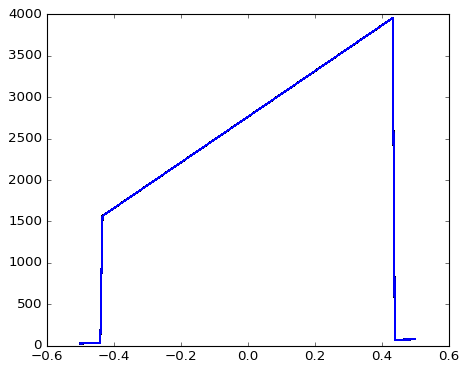

In [163]:
pp=0
    
# Combined mesh and space on it
V = FunctionSpace(mesh, 'DG', 2)

mesh0 = SubMesh(mesh, subdomains, 0)
mesh1 = SubMesh(mesh, subdomains, 1)
# Create functions in parts
V0 = FunctionSpace(mesh, 'DG', 2)
u0 = project(sigma_vec(v,0,Eps)[pp], V0)

V1 = FunctionSpace(mesh, 'DG', 2)
u1 = project(sigma_vec(v,1,Eps)[pp], V1)

# Begin glueing
uu = TrialFunction(V)
vv = TestFunction(V)
aa = inner(uu, vv)*dx

# Function v0 is u0 in mesh0 and 0 otherwise
L0 = inner(u0, vv)*dx(0, subdomain_data=subdomains)
v0 = Function(V)
solve(aa == L0, v0)

# Function v1 is u1 in mesh1 and 0 otherwise
L1 = inner(u1, vv)*dx(1, subdomain_data=subdomains)
v1 = Function(V)
solve(aa == L1, v1)

# Combine
vvv = Function(V, v0.vector())
vvv.vector()[:] += v1.vector()
stress_gp=vvv.vector().get_local()

# plt.figure()
#p = plot(vvv)
#plt.colorbar(p)
#q=plot(mesh)
#plt.show()
z_FE=[]
for i in range(len(x)):
        z_FE.append(vvv(x[i],y[i]))

z = stress_sc[:,pp]

 # FEniCS Data
m=0.5
N=1000
xi_22 = np.linspace(0, 0, N)
yi_22 = np.linspace(-m, m, N)
st_22 = scipy.interpolate.griddata((x, y), z_FE, (xi_22[None,:], yi_22[:,None]))
st_SC = scipy.interpolate.griddata((x, y), z, (xi_22[None,:], yi_22[:,None]))
# st_SC = scipy.interpolate.griddata((x, y, z), stress_sc[pp], (xi_22[None,:], yi_22[:,None],zi[:,None]))
fig = plt.figure(facecolor='white' , figsize=(6,4.8))
p1=plt.plot(yi_22, st_22,color='red',label="FEniCS")
p2=plt.plot(yi_22, st_SC,color='blue',label="SC")
#plt.ylim(top=max(z))  # adjust the top leaving bottom unchanged
#plt.ylim(bottom=min(z))  # adjust the bottom leaving top unchanged
#p=plt.plot(yi_22, st_SC,color='green', label='SwiftComp')
plt.show()

In [164]:
for i in range(len(z_FE)):
    print(z_FE[i])

42.97576529706559
43.897562276343805
43.03467384668733
43.460668683336365
43.49539992683858
42.951932289467884
43.30266711362766
44.04639634199263
44.084963189249095
43.16685675709606
44.11935347619932
43.600800304425064
43.57806244134967
43.766072225145656
44.296991811775584
45.2065225431791
44.34893021562691
44.775812060201176
44.806433887078626
44.270198109325264
44.617481498759346
43.05620152186279
43.962237491043176
43.109994249051084
43.53305954303169
43.564774191717675
43.030599015354625
43.37614410451636
45.35121882913042
45.38120483611425
44.478116306620905
45.41924494756127
44.90448689438534
44.886808069596306
45.07018012103997
45.26143484231625
44.40831207532653
44.360291991910856
44.863213832984925
44.331923001599826
44.83490258445456
44.67667932068531
45.405727385471636
45.430828461169355
44.537802530470024
45.47085629396891
44.95915034814236
44.94435128528782
45.1247864633874
44.11020768393536
44.14678200619739
43.24272997829161
44.18138908344039
43.66994676282637
43.6483

Solving linear variational problem.
Solving linear variational problem.


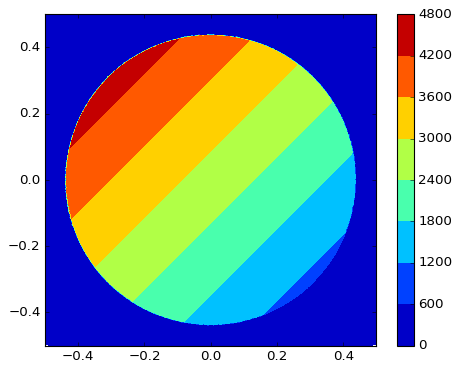

Solving linear variational problem.
Solving linear variational problem.


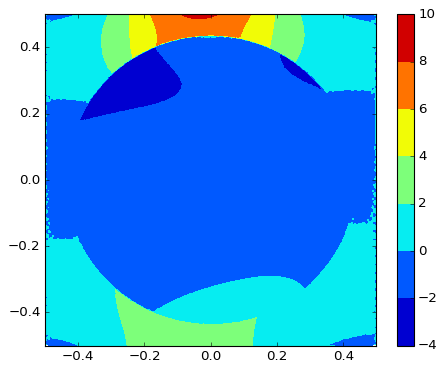

Solving linear variational problem.
Solving linear variational problem.


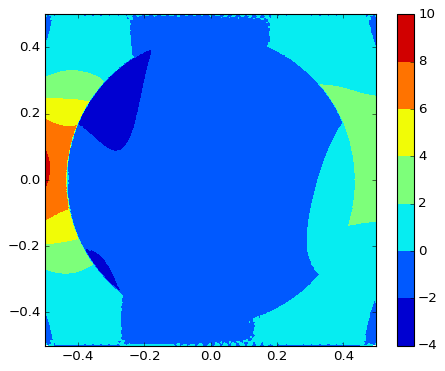

Solving linear variational problem.
Solving linear variational problem.


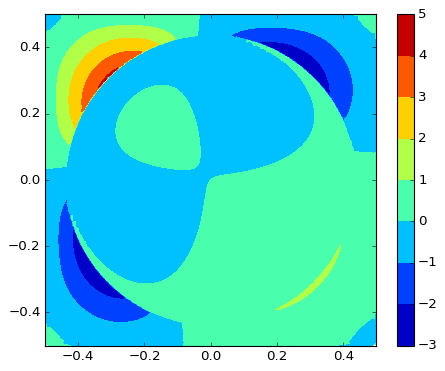

Solving linear variational problem.
Solving linear variational problem.


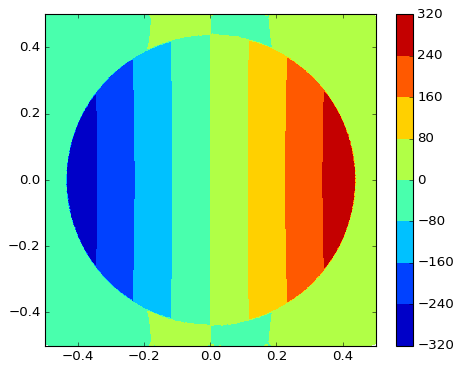

Solving linear variational problem.
Solving linear variational problem.


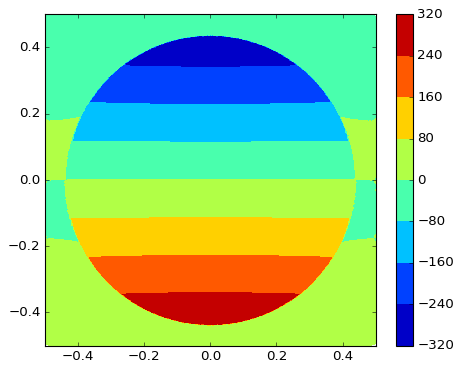

In [165]:
# SURFACE PLOTS FEniCS  

for pp in range(6):
    # Combined mesh and space on it
    V = FunctionSpace(mesh, 'DG', 2)

    mesh0 = SubMesh(mesh, subdomains, 0)
    mesh1 = SubMesh(mesh, subdomains, 1)
    # Create functions in parts
    V0 = FunctionSpace(mesh, 'DG', 2)
    u0 = project(sigma_vec(v,0,Eps)[pp], V0)

    V1 = FunctionSpace(mesh, 'DG', 2)
    u1 = project(sigma_vec(v,1,Eps)[pp], V1)

    # Begin glueing
    uu = TrialFunction(V)
    vv = TestFunction(V)
    aa = inner(uu, vv)*dx

    # Function v0 is u0 in mesh0 and 0 otherwise
    L0 = inner(u0, vv)*dx(0, subdomain_data=subdomains)
    v0 = Function(V)
    solve(aa == L0, v0)

    # Function v1 is u1 in mesh1 and 0 otherwise
    L1 = inner(u1, vv)*dx(1, subdomain_data=subdomains)
    v1 = Function(V)
    solve(aa == L1, v1)

    # Combine
    vvv = Function(V, v0.vector())
    vvv.vector()[:] += v1.vector()
    stress_gp=vvv.vector().get_local()

    #plt.figure()
    #p = plot(vvv)
    #plt.colorbar(p)
    #q=plot(mesh)

    plt.show()
    st_FE=[]
    for i in range(len(x)):
            st_FE.append(vvv(x[i],y[i]))
    
    
    z = stress_sc[:,pp]

     # FEniCS Data
    N=1000
    xi = np.linspace(-0.5, 0.5, N)
    yi = np.linspace(-0.5, 0.5, N)
    zi = scipy.interpolate.griddata((x, y), st_FE, (xi[None,:], yi[:,None]))
    fig = plt.figure(facecolor='white', figsize=(6,4.8))
    p=plt.contourf(xi, yi, zi)
    plt.colorbar(p)
    plt.rcParams["figure.autolayout"] = True
    #ax = plt.gca()
    #ax.set_facecolor("white")
    
    plt.show()

-20.217288634638503
-98.74856485809042
-73.87664317890454
-58.62337845125521
-90.25953225802131
-43.9595451473413
-64.28081986781072
-117.0281775993452
-159.48157006301713
-91.17692096638264
-141.06615031977674
-125.82494800219999
-100.79554069512577
-122.56221507033915
-131.67312955469572
-205.57966429854423
-174.1818952953136
-168.29462990717963
-193.35669203721295
-149.783328213787
-170.47821974805117
-93.34186221153679
-161.71602737214272
-134.4927654430877
-127.11308387104657
-151.37457731909387
-111.06295789709924
-129.85020398355573
-221.23716596386805
-254.11382054292233
-189.62536315851406
-240.5448260701663
-221.90735597224585
-202.52414415673462
-221.65877902004206
-254.16459657621104
-221.7394875163295
-189.66449639109464
-240.8355980233048
-202.807990675731
-221.92502617647477
-221.8561782222894
-267.10079153645273
-291.4580909498234
-234.36434511024933
-281.9615903862646
-262.66102711075587
-248.30059717925047
-264.30776302222694
-176.42703685153222
-208.02788932059806
-1

In [75]:
from ffc.fiatinterface import create_quadrature as cquad
shape = "triangle"
deg = 1
scheme = "default"

points, weights = cquad(shape, deg, scheme)
points

array([[0.33333333, 0.33333333]])

In [38]:
#xyz of gp
a=np.array([(0.33333,0.166666),(0.833333,0.166666),(0.833333,0.666666)])

gamma_e1=np.array([(1,0,0,0,0,0),(0,0,0,0,a[0,0],-a[0,1]),(a[0,1],0,0,0,0,0),(-a[0,0],0,0,0,0,0)])
gamma_eT1=gamma_e1.T

# D_ee calculate
D_ee_c=1/6*np.matmul(np.matmul(gamma_e1,D),gamma_eT1)

gamma_e2=np.array([(1,0,0,0,0,0),(0,0,0,0,a[1,0],-a[1,1]),(a[1,1],0,0,0,0,0),(-a[1,0],0,0,0,0,0)])
gamma_eT2=gamma_e1.T

D_ee_c=D_ee_c+1/6*np.matmul(np.matmul(gamma_e2,D),gamma_eT2)

gamma_e3=np.array([(1,0,0,0,0,0),(0,0,0,0,a[2,0],-a[2,1]),(a[2,1],0,0,0,0,0),(-a[2,0],0,0,0,0,0)])
gamma_eT3=gamma_e1.T

D_ee_c=D_ee_c+1/6*np.matmul(np.matmul(gamma_e3,D),gamma_eT3)
print(D_ee_c)


[[ 4209.43290286     0.           701.56934419 -1403.13026951]
 [    0.           241.27882158     0.             0.        ]
 [ 1403.14149467     0.           233.85598035  -467.70915442]
 [-2806.28298933     0.          -467.7119607    935.41830883]]


In [129]:
# D_ee SC
#gp=1
a=np.array([(0.666666,0.333333)])
gamma_e1=np.array([(1,0,0,0,0,0),(0,0,0,0,a[0,0],-a[0,1]),(a[0,1],0,0,0,0,0),(-a[0,0],0,0,0,0,0)])
#print(gamma_e1)
dee_e1=0.5*np.matmul(np.matmul(gamma_e1,D),gamma_e1.T)
print(dee_e1)

a=np.array([(0.3333,0.6666)])
gamma_e2=np.array([(1,0,0,0,0,0),(0,0,0,0,a[0,0],-a[0,1]),(a[0,1],0,0,0,0,0),(-a[0,0],0,0,0,0,0)])
#print(gamma_e2)
dee_e2=0.5*np.matmul(np.matmul(gamma_e2,D),gamma_e2.T)
print(dee_e2)

# D_ee calculate
D_ee_c22=dee_e1+dee_e2
print(D_ee_c22)

[[ 4209.43290286     0.          1403.14289781 -2806.28579562]
 [    0.           482.5618897      0.             0.        ]
 [ 1403.14289781     0.           467.71383156  -935.42766311]
 [-2806.28579562     0.          -935.42766311  1870.85532622]]
[[ 4209.43290286     0.          2806.00797305 -1403.00398652]
 [    0.           482.46634708     0.             0.        ]
 [ 2806.00797305     0.          1870.48491483  -935.24245742]
 [-1403.00398652     0.          -935.24245742   467.62122871]]
[[ 8418.86580573     0.          4209.15087086 -4209.28978214]
 [    0.           965.02823678     0.             0.        ]
 [ 4209.15087086     0.          2338.19874639 -1870.67012053]
 [-4209.28978214     0.         -1870.67012053  2338.47655493]]


In [127]:
dee=as_tensor([(D[0,0], D[0,4]*x[0]-D[0,5]*x[1], D[0,0]*x[1], -D[0,0]*x[0]),
              (D[4,0]*x[0]-D[5,0]*x[1], x[0]*(D[4,4]*x[0]-D[5,4]*x[1])-x[1]*(D[4,5]*x[0]-D[5,0]*x[1]), x[1]*(D[4,0]*x[0]-D[5,0]*x[1]), -x[0]*(D[4,0]*x[0]-D[5,0]*x[1])),
              (D[0,0]*x[1], D[0,4]*x[0]*x[1], D[0,0]*pow(x[1],2), -D[0,0]*x[0]*x[1]),
               (-D[0,0]*x[0], -D[0,4]*pow(x[0],2)+D[0,5]*x[0]*x[1], -D[0,0]*x[0]*x[1], D[0,0]*pow(x[0],2))])

In [134]:
assemble(pow(x[0],2)*dx)

0.33333333333333326

In [135]:
#Dee FEniCS try
x = SpatialCoordinate(mesh)
Eps2T=as_tensor([(1,0,0,0,0,0),
                (0,0,0,0,x[0],-x[1]),
                (x[1],0,0,0,0,0),
                (-x[0],0,0,0,0,0)]) 

Eps2=as_tensor([(1,0,x[1],-x[0]),
                (0,0,0,0),
                (0,0,0,0),
                (0,0,0,0),
               (0,x[0],0,0),
               (0,-x[1],0,0)])

for s in range(4):
    for k in range(4): 
        D_ee[s,k]=assemble(dee[s,k]*dx)
D_ee

array([[ 8418.86580573,     0.        ,  4209.43290286, -4209.43290286],
       [    0.        ,   579.07542579,     0.        ,     0.        ],
       [ 4209.43290286,     0.        ,  2806.28860191, -2104.71645143],
       [-4209.43290286,     0.        , -2104.71645143,  2806.28860191]])

In [121]:
#p1=0.5*(np.matmul(gamma_e1,gamma_e1.T)+np.matmul(gamma_e2,gamma_e2.T))

array([[ 1.        ,  0.        ,  0.4999665 , -0.499983  ],
       [ 0.        ,  0.55549945,  0.        ,  0.        ],
       [ 0.4999665 ,  0.        ,  0.27773322, -0.22219978],
       [-0.499983  ,  0.        , -0.22219978,  0.27776622]])

In [125]:
DI=np.identity(6)

D_eet=np.zeros((4,4))
for s in range(4):
    for k in range(4): 
        D_eet[s,k]=assemble(dot(as_tensor(DI),as_tensor(p1)))[s,k]*dx)
D_eet

Shapes do not match: <ListTensor id=140401407192000> and <ListTensor id=140401741830720>.


UFLException: Shapes do not match: <ListTensor id=140401407192000> and <ListTensor id=140401741830720>.

In [207]:
# gamma_h

jac=np.array([(1,0),(-1,1)])
der_n=np.array([(-1,-1),(1,0),(0,1)])

der_g=np.matmul(der_n,jac.T)
#print(der_g)

# Form gamma_h
gamma_h=np.array([(0,0,0,0,0,0,0,0,0),(0,-1,0,0,1,0,0,0,0),(0,0,0,0,0,-1,0,0,1),(0,0,-1,0,-1,1,0,1,0),(0,0,0,-1,0,0,1,0,0),(-1,0,0,1,0,0,0,0,0)])

#print(gamma_h)

Asp_c=0.5*np.matmul(np.matmul(gamma_h.T,D),gamma_h)
print(Asp_c) 

[[  868.61313869     0.             0.          -868.61313869
      0.             0.             0.             0.
      0.        ]
 [    0.          4209.43290286     0.             0.
  -4209.43290286  2472.20662549     0.             0.
  -2472.20662549]
 [    0.             0.           868.61313869     0.
    868.61313869  -868.61313869     0.          -868.61313869
      0.        ]
 [ -868.61313869     0.             0.          1737.22627737
      0.             0.          -868.61313869     0.
      0.        ]
 [    0.         -4209.43290286   868.61313869     0.
   5078.04604155 -3340.81976418     0.          -868.61313869
   2472.20662549]
 [    0.          2472.20662549  -868.61313869     0.
  -3340.81976418  5078.04604155     0.           868.61313869
  -4209.43290286]
 [    0.             0.             0.          -868.61313869
      0.             0.           868.61313869     0.
      0.        ]
 [    0.             0.          -868.61313869     0.
   -868.61313869

In [99]:
#for i in range(9):
    #for j in range(9):
      #  print(j+1,i+1,Asp_c[j,i])


array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
# constraint_el

Const_LM=np.array([(1/6, 0, 0, 1/6,0, 0,1/6,0,0),(0,1/6, 0, 0, 1/6,0, 0,1/6,0),(1/6, 0, 0, 1/6,0, 0,1/6,0,0),()])

In [216]:
# Dhe SC

Dhe_c=0.5*np.matmul(np.matmul(gamma_h.T,D),gamma_e1.T)
print(Dhe_c) 

[[    0.           289.53742336     0.             0.        ]
 [-2472.20662549     0.          -824.06805109  1648.13610219]
 [    0.             0.             0.             0.        ]
 [    0.          -868.61227007     0.             0.        ]
 [ 2472.20662549     0.           824.06805109 -1648.13610219]
 [-2472.20662549     0.          -824.06805109  1648.13610219]
 [    0.           579.07484672     0.             0.        ]
 [    0.             0.             0.             0.        ]
 [ 2472.20662549     0.           824.06805109 -1648.13610219]]


In [220]:
#FEniCS
Dhe[:xx-4,:xx-4]

array([[    0.        ,   868.61313869,     0.        ,     0.        ],
       [    0.        ,  -289.5377129 ,     0.        ,     0.        ],
       [    0.        ,  -579.07542579,     0.        ,     0.        ],
       [ 2472.20662549,     0.        ,   824.06887516, -1648.13775033],
       [-2472.20662549,     0.        ,  -824.06887516,  1648.13775033],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [ 2472.20662549,     0.        ,   824.06887516, -1648.13775033],
       [-2472.20662549,     0.        ,  -824.06887516,  1648.13775033]])

In [224]:
Eps=Eps2[:,1] 
# F = sum([inner(sigma(dv, i, Eps)[0], (eps_t(v_)[0] + Eps2T_ten(Eps)))*dx(i) for i in range(nphases)])
F = inner(sigma(dv, 0, Eps), eps_t(v_))*dx
L = rhs(F)      
w = Function(W) 
solve(a == L, w,[])       
#V0[:,1]= (w.vector().get_local()) # V0 matrix formation
Dhe[:,1]= assemble(L).get_local() # Dhe matrix formation


        

Solving linear variational problem.


In [9]:
E, nu = material_parameters[0]
lmbda = E*nu/((1+nu)*(1-2*nu))
mu = E/2/(1+nu)
C1=lmbda+2*mu
D= np.array([(C1,lmbda,lmbda,0,0,0),(lmbda,C1,lmbda,0,0,0),(lmbda,lmbda,C1,0,0,0),(0,0,0,mu,0,0),(0,0,0,0,mu,0),(0,0,0,0,0,mu)])
D

array([[8418.86580573, 4944.41325098, 4944.41325098,    0.        ,
           0.        ,    0.        ],
       [4944.41325098, 8418.86580573, 4944.41325098,    0.        ,
           0.        ,    0.        ],
       [4944.41325098, 4944.41325098, 8418.86580573,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , 1737.22627737,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
        1737.22627737,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        , 1737.22627737]])

In [11]:
# FEniCS V0
for i in range(4):
    for j in range(13):
        print(j+1,i+1,V0[j,i])       

1 1 0.0
2 1 0.0
3 1 0.0
4 1 0.24666666666666667
5 1 -0.12333333333333349
6 1 -0.12333333333333335
7 1 0.12333333333333316
8 1 0.12333333333333331
9 1 -0.24666666666666662
10 1 0.0
11 1 0.0
12 1 -3.6812880786047096e-13
13 1 4.547473508864641e-13
1 2 0.33333333333333326
2 2 6.543530530135999e-17
3 2 -0.3333333333333333
4 2 0.0
5 2 0.0
6 2 0.0
7 2 0.0
8 2 0.0
9 2 0.0
10 2 0.0
11 2 0.0
12 2 0.0
13 2 0.0
1 3 0.0
2 3 0.0
3 3 0.0
4 3 0.08222222222222221
5 3 -0.04111111111111115
6 3 -0.04111111111111113
7 3 0.04111111111111108
8 3 0.04111111111111109
9 3 -0.08222222222222221
10 3 0.0
11 3 -3.410605131648482e-13
12 3 2.1654635756498322e-14
13 3 1.1368683772161603e-13
1 4 0.0
2 4 0.0
3 4 0.0
4 4 -0.16444444444444437
5 4 0.08222222222222232
6 4 0.08222222222222217
7 4 -0.08222222222222213
8 4 -0.08222222222222228
9 4 0.1644444444444445
10 4 0.0
11 4 6.821210263296964e-13
12 4 -1.2992781453898992e-13
13 4 -6.821210263296962e-13


In [34]:
print(D1)

NameError: name 'D1' is not defined

In [ ]:
el = FiniteElement("Quadrature", mesh.ufl_cell(),  degree=2, quad_scheme="default")
V = FunctionSpace(mesh, el)
#print(V.tabulate_dof_coordinates())
#len(V.tabulate_dof_coordinates())
coord_gp=V.tabulate_dof_coordinates()
x_FE=coord_gp[:,0]
y_FE=coord_gp[:,1]


In [39]:
from __future__ import print_function
from dolfin import *
import numpy as np
mesh = UnitSquareMesh(5,5)

E, nu = 4760,0.25
lmbda = E*nu/((1+nu)*(1-2*nu))
mu = E/2/(1+nu)
C1=lmbda+2*mu
Comp = as_tensor([(C1,lmbda,lmbda,0,0,0),(lmbda,C1,lmbda,0,0,0),(lmbda,lmbda,C1,0,0,0),(0,0,0,mu,0,0),(0,0,0,0,mu,0),(0,0,0,0,0,mu)])
   
def fun_l(v):
    E1=as_tensor([(v[0].dx(0),0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,v[2].dx(0)),(0,v[1].dx(0),0)])
    return E1

def fun_lT(v):
    E2=as_tensor([(v[0].dx(0),0,0,0,0,0),(0,0,0,0,0,v[2].dx(0)),(0,0,0,0,v[1].dx(0),0)])
    return E2

Ve = VectorElement("CG", mesh.ufl_cell(), 1,dim=3)
Re = VectorElement("R", mesh.ufl_cell(), 0,dim=3)
W = FunctionSpace(mesh, MixedElement([Ve, Re]))
V = FunctionSpace(mesh, Ve)

v_,lamb_ = TestFunctions(W)
dv, dlamb = TrialFunctions(W)

dx = Measure('dx')(domain=mesh)

# Global Assembly matrix

a1=dot(fun_lT(dv),dot(Comp,fun_l(v_)))*dx


Can only integrate scalar expressions. The integrand is a tensor expression with value shape (3, 3) and free indices with labels ().


UFLException: Can only integrate scalar expressions. The integrand is a tensor expression with value shape (3, 3) and free indices with labels ().

In [41]:
type(fun_l(dv))

ufl.tensors.ListTensor

In [38]:
fun_l(v_)

ListTensor(ListTensor(Indexed(Grad(Indexed(Argument(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 205), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=3), VectorElement(FiniteElement('Real', triangle, 0), dim=3))), 0, None), MultiIndex((FixedIndex(0),)))), MultiIndex((FixedIndex(0),))), Zero((), (), ()), Zero((), (), ())), Zero((3,), (), ()), Zero((3,), (), ()), Zero((3,), (), ()), ListTensor(Zero((), (), ()), Zero((), (), ()), Indexed(Grad(Indexed(Argument(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 205), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=3), VectorElement(FiniteElement('Real', triangle, 0), dim=3))), 0, None), MultiIndex((FixedIndex(2),)))), MultiIndex((FixedIndex(0),)))), ListTensor(Zero((), (), ()), Indexed(Grad(Indexed(Argument(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 205), MixedElement(VectorElement(FiniteElem

In [ ]:
import symfem
print(symfem.create_element("triangle", "Lagrange", order=1).get_basis_functions())

In [212]:
import dolfin
from ufl import Jacobian
J = dolfin.det(Jacobian(mesh))

Q = dolfin.FunctionSpace(mesh, "DG", 0)
cell_jac = dolfin.project(J, Q)
print(cell_jac.vector().get_local())

Calling FFC just-in-time (JIT) compiler, this may take some time.
[1.]
